In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys 
from os import pardir, mkdir 
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

In [3]:
# from utils import rhoDD, frho, rho_tot, f, fdist, nu, nu_mod
from utils import nu_mod, nu, nu_bootstrap, f

In [4]:
root_data_dir = abspath(join(pardir, "Data"))
name = "Baryon"
data_dir_baryon = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(data_dir_baryon, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# Framework

Following Buch et. al. ([2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))

let $\mathcal{M}$ be a model characterized by parameters $\theta=\{\psi, \xi\}$, such that $\psi=\{\rho_\text{DM}, \Sigma_\text{DM}, h_\text{DM}\}$ are the parameters of interest, and $\xi=\{\rho_i, \sigma_{z;i}, N_\nu, z_\odot\}$

The likelihood is
\begin{aligned}
  p_\nu(d|\mathcal{M}, \theta) = \prod_{i=1}^{N_z} \frac{1}{\sqrt{2\pi \sigma^2_{\text{ln }\nu_i}}}\exp{\left(-\frac{\left[\text{ln}(N_\nu \nu_i^{\text{mod}})-\text{ln } \nu_i^\text{data}\right]^2}{2\sigma^2_{\text{ln }\nu_i}}\right)}
\end{aligned}

Where
* $\nu_i^{\text{mod}}$ is given by `nu_mod` in utils.py
* $\nu_i^{\text{data}}$ is given by `Data/Number-Density/density.hdf5`
* $\sigma^2_{\text{ln }\nu_i}$ is total uncertainty

Total uncertainty is
\begin{aligned}
  \sigma^2_{\text{ln }\nu_i} = \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod}+\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{data}
\end{aligned} 

With the following source of uncertainties
| Type | Source | Treatment |
| ---- | ------ | --------- |
| data | Poisson| sqrt(N)   |
|      | 3% dust| 3% * data |
| mod  | stats  | bootstrap res. |
|      | sys    | asym |

Where the mod uncertainty is
\begin{aligned}
  \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod} = \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, stat}+\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys}
\end{aligned} 

$\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, stat}$ is estimated using bootstrap resampling, and

$\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys}$ is estimated from the asymmetry of vertical vel. dist.,
\begin{aligned}
  \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys} \approx |\text{ln }\nu^{(w>0)}-\text{ln }\nu^{(w<0)}|
\end{aligned}

## Bootstrap resampling
Check the detail in [Schutz, K., Lin, T., Safdi, B. R., & Wu, C. L. (2018). Constraining a Thin Dark Matter Disk with G a i a. Physical review letters, 121(8), 081101](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.081101) Appendix D

In [22]:
root_data_dir = abspath(join(pardir, "Data"))
data_velocity_dist_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_velocity_dist_dir

'/home2/s20321005/Thesis-Project/Data/Spectral-Class-Velocity'

In [6]:
a_type = vaex.open(join(data_velocity_dist_dir, "A-type.hdf5"))
f_type = vaex.open(join(data_velocity_dist_dir, "F-type.hdf5"))
g_type = vaex.open(join(data_velocity_dist_dir, "G-type.hdf5"))
g_type

#,w,e_w,spectraltype_esphs
0,-9.590023669072771,0.023956980727508907,F
1,16.547108022089976,0.010300926715071157,G
2,33.16147423530458,0.03313949612412754,G
3,23.232425874782766,0.03457258873567302,G
4,6.200975829380684,0.01760915737454791,G
...,...,...,...
"1,325",16.01534653457238,0.027898021529253764,G
"1,326",-7.1882994564791955,0.012496910009595399,G
"1,327",14.107354617379562,0.018691735437401776,G
"1,328",9.275137350974589,0.013502434199310931,G


example for resampling

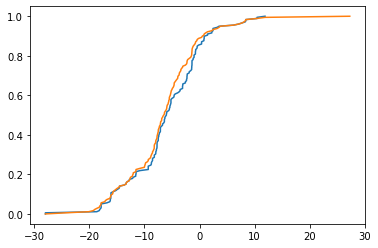

In [7]:
# Resample with replacement
a_type_resampled = a_type.sample(frac=1, replace=True)
# compare
a_num_resampled = a_type_resampled.w.to_numpy()
a_num_resampled = np.sort(a_num_resampled)
a_num = a_type.w.to_numpy()
a_num = np.sort(a_num)
# # plot cumulative
plt.plot(a_num_resampled, np.linspace(0, 1, len(a_num_resampled)))
plt.plot(a_num, np.linspace(0, 1, len(a_num)))

In [8]:
def fdist_cum(w, sigma, w0):
  return norm.cdf(w, loc=w0, scale=sigma)
def fdist_pdf(w, sigma, w0):
  return norm.pdf(w, loc=w0, scale=sigma)

In [9]:
popt, pcov = curve_fit(fdist_cum, a_num, np.linspace(0, 1, len(a_num)), p0=(1,0))
popt

array([ 5.69572671, -6.52279594])

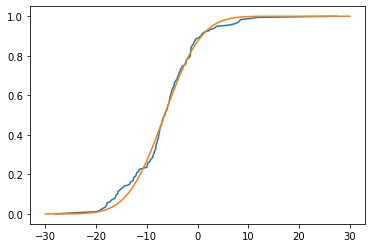

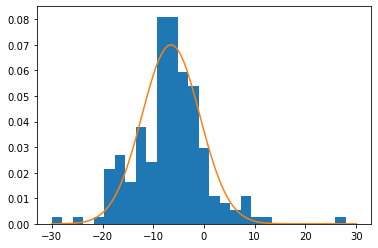

In [10]:
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(a_num, np.linspace(0, 1, len(a_num)))
plt.plot(ws, fdist_cum(ws, *popt))
plt.show()
plt.figure()
plt.hist(a_num, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt))
plt.show()

In [11]:
popt_r, pcov = curve_fit(fdist_cum, a_num_resampled, np.linspace(0, 1, len(a_num)), p0=(1,0))
popt_r

array([ 6.1453081 , -5.77032904])

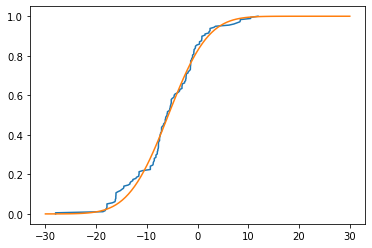

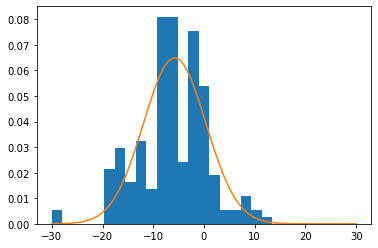

In [12]:
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(a_num_resampled, np.linspace(0, 1, len(a_num_resampled)))
plt.plot(ws, fdist_cum(ws, *popt_r))
plt.show()
plt.figure()
plt.hist(a_num_resampled, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt_r))
plt.show()

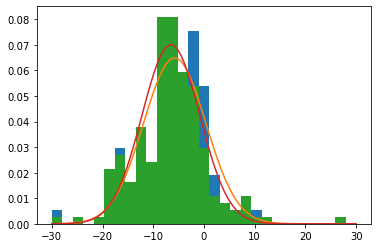

In [13]:
plt.figure()
plt.hist(a_num_resampled, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt_r))
plt.hist(a_num, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt))
plt.show()

# Bootstrap resampling

In [66]:
# create 1000 bootstrap samples
for t, c in [(a_type, "A"), (f_type, "F"), (g_type, "G")]:
  df = []
  for i in range(1000):
    resampled = t.sample(frac=1, replace=True)
    num_resampled = resampled.w.to_numpy()
    num_resampled = np.sort(num_resampled)
    popt_r, _ = curve_fit(fdist_cum, num_resampled, np.linspace(0, 1, len(num_resampled)), p0=(1,0))
    sigma_v, w0 = popt_r
    cols = dict(sigma_v=[sigma_v], w0=[w0], sample=[i])
    df_new = vaex.from_dict(cols)
    if len(df) == 0:
      df = df_new
    else:
      df = df.concat(df_new)
  df.export(join(data_dir, f"{c}-type-bootstrap.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     1.64s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     1.73s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.72s =  0.0m =  0.0h
 

In [18]:
a_bootstrap_type = vaex.open(join(data_dir, "A-type-bootstrap.hdf5"))
f_bootstrap_type = vaex.open(join(data_dir, "F-type-bootstrap.hdf5"))
g_bootstrap_type = vaex.open(join(data_dir, "G-type-bootstrap.hdf5"))
a_bootstrap_type

#,sigma_v,w0,sample
0,5.788585360683395,-7.236451773135977,0
1,4.6788341506745565,-6.195221483859772,1
2,6.109099400027174,-6.797145826910388,2
3,5.9757782234666905,-6.862668013704516,3
4,5.603674560082213,-7.209796290451144,4
...,...,...,...
995,7.003022582941199,-6.529369648608863,995
996,5.410044015088829,-6.958005597138357,996
997,7.10915076532003,-6.377562354029689,997
998,5.050851152086821,-6.10379377607252,998


The first sample

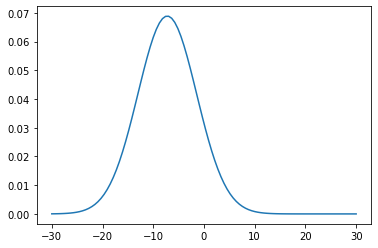

In [19]:
w0 = a_bootstrap_type.w0.to_numpy()[0]
sigma_v = a_bootstrap_type.sigma_v.to_numpy()[0]
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(ws, fdist_pdf(ws, sigma_v, w0))

In [45]:
# for a given set of sigma_v and w0, compute the nu for each sample
phis = np.linspace(0, 1000, 1001)
logNus = dict(A=[], F=[], G=[])
for t, c in [(a_bootstrap_type, "A"), (f_bootstrap_type, "F"), (g_bootstrap_type, "G")]:
  for i, sigma in enumerate(t.sigma_v.to_numpy()):  
    nus = nu(phis, sigma)
    logNu = np.log(nus)
    logNus[c].append(logNu)
  logNus[c] = np.array(logNus[c])

In [65]:
logNus_mean = {c: logNus[c].mean(axis=0) for c in ["A", "F", "G"]}
logNus_std = {c: logNus[c].std(axis=0) for c in ["A", "F", "G"]}

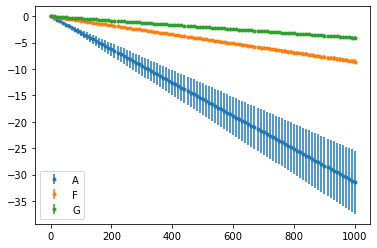

In [81]:
for c in ["A", "F", "G"]:
  plt.errorbar(phis[::10], logNus_mean[c][::10], yerr=logNus_std[c][::10], fmt='.' ,label=c)
plt.legend()

## doing some "research"

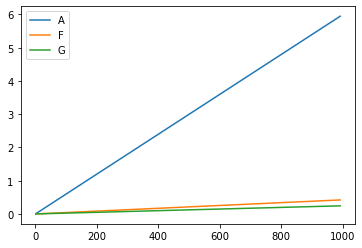

In [86]:
for c in ["A", "F", "G"]:
  plt.plot(phis[1::10], logNus_std[c][1::10],label=c)
plt.legend()

it looks like, the error is proportional to the mean
\begin{aligned}
  \sigma_{\text{ln }\nu}(\Phi) = a \Phi
\end{aligned}

or, even

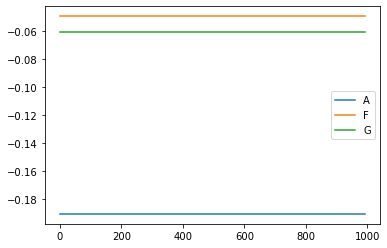

In [96]:
for c in ["A", "F", "G"]:
  plt.plot(phis[1::10], logNus_std[c][1::10]/logNus_mean[c][1::10],label=c)
plt.legend()

\begin{aligned}
  \sigma_{\text{ln }\nu}(\Phi) = b {\text{ ln }\nu}(\Phi)
\end{aligned}

In [98]:
b = {c: [np.mean(logNus_std[c][1::]/logNus_mean[c][1::])] for c in ["A", "F", "G"]}
b

{'A': [-0.1906456477812084],
 'F': [-0.049303821247208515],
 'G': [-0.0603049887590651]}

In [99]:
# df_stats = vaex.from_dict(dict(phis=phis, logNuA=logNus_mean["A"], logNuF=logNus_mean["F"], logNuG=logNus_mean["G"], logNuA_std=logNus_std["A"], logNuF_std=logNus_std["F"], logNuG_std=logNus_std["G"]))
df_stats = vaex.from_dict(b)
df_stats

#,A,F,G
0,-0.190646,-0.0493038,-0.060305


In [76]:
name = "Uncertainty"
data_dir = join(root_data_dir, name)
try:
  mkdir(data_dir)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Creating Uncertainty dir in Data dir


In [100]:
df_stats.export(join(data_dir, "stats.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.09s =  0.0m =  0.0h
 

## Test Bootstrap resampling

In [11]:
name = "Uncertainty"
data_unc_dir = join(root_data_dir, name)
data_unc_dir

'/home2/s20321005/Thesis-Project/Data/Uncertainty'

In [13]:
df_stats = vaex.open(join(data_unc_dir, "stats.hdf5"))
df_stats

#,A,F,G
0,-0.190646,-0.0493038,-0.060305


In [12]:
name = "Velocity-Distribution"
data_velocity_dir = join(root_data_dir, name)
data_velocity_dir

'/home2/s20321005/Thesis-Project/Data/Velocity-Distribution'

In [14]:
df_velocity = vaex.open(join(data_velocity_dir, "Velocity-Distribution.hdf5"))
df_velocity

#,type,wo,sigma,A
0,A,-5.98941,4.91812,321.274
1,F,-6.73832,9.91148,3054.33
2,G,-7.04128,13.7909,2437.44


In [79]:
from operator import itemgetter
from scipy.integrate import odeint
from scipy import interpolate
# this function should be in utils.py
# def nu_bootstrap(zz, theta, tipe="A",  res=1000):
#   data_dir = join(root_data_dir, name)
#   df_stats = vaex.open(join(data_dir, "stats.hdf5"))
#   args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nv', 'zsun')
#   rhos, sigmaz, rhoDM, sigmaDD, hDD, Nv, zsun = itemgetter(*args)(theta)

#   phi0 = 0 # (km/s)^2
#   Kz0 = 0 # pc (km/s)^2

#   y0 = [Kz0, phi0]
#   zmax = np.max(np.abs(zz+zsun))
#   zs = np.linspace(0, zmax*1000, res)
#   us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD))
#   phi = us[:, 0]
#   phi_interp_pos = interpolate.interp1d(zs, phi, kind='cubic')
#   phi_interp = lambda z: phi_interp_pos(np.abs(z)*1000)
#   phii = phi_interp(zz+zsun)
#   data_dir = join(root_data_dir,"Velocity-Distribution")
#   df_velocity = vaex.open(join(data_dir, "Velocity-Distribution.hdf5"))
#   index = 0 if tipe == "A" else 1 if tipe == "F" else 2
#   sigma_v = df_velocity["sigma"].to_numpy()[index]
#   nus = nu(phii, sigma_v)
#   logNu = np.log(nus)
#   b = df_stats[tipe].to_numpy()[0]
#   logNu_std = b*logNu
#   return logNu, logNu_std

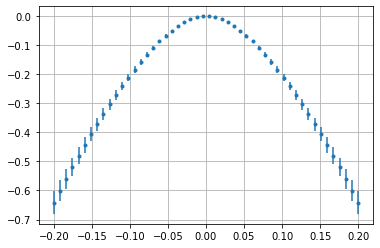

In [82]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0.0)

zz = np.linspace(-0.2, 0.2, 50)
logNu, logNu_std = nu_bootstrap(zz, theta, tipe="G")
plt.errorbar(zz, logNu, yerr=logNu_std, fmt='.')
plt.grid()

In [129]:
# run 100 bootstrap resampling
# sigmas = a_bootstrap_type.sigma_v.to_numpy()
# N = len(sigmas)
# zz = np.linspace(1, 200, 22)
# Zs = np.zeros((N, len(zz)*2))
# Nus = np.zeros((N, len(zz)*2))

# # initial values
# rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
# sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# # test the following dark values
# rhoDM = 0.016 # Msun/pc^3
# sigmaDD = 7 # Msun/pc^2
# hDD = 20 # pc

# theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

# for i, sigma_v in enumerate(sigmas):
#   # w0 = a_bootstrap_type.w0.to_numpy()[0]
#   Zs[i], Nus[i] = nu_mod(zz, theta, sigma_v)
#   if (i % 100 == 0): print(i, end=" ")

In [128]:
# Nu_mean = np.mean(Nus, axis=0)
# Nu_std = np.std(Nus, axis=0)
# plt.errorbar(Zs[0], Nu_mean, yerr=Nu_std, fmt=".")

In function form

In [11]:
# this function is in utils.py
# def bootstrap_resampling(func, theta, sigmas, zz):
#   """Bootstrap resampling of a function with a distribution"""
#   # run N bootstrap resampling
#   Zs = np.zeros((len(sigmas), len(zz)*2))
#   Nus = np.zeros((len(sigmas), len(zz)*2))

#   for i, sigma in enumerate(sigmas):
#     Zs[i], Nus[i] = func(zz, theta, sigma)
#     if (i % 100 == 0): print(i, end=" ")
#   print(f"{i} end")
#   Nu_mean = np.mean(Nus, axis=0)
#   Nu_std = np.std(Nus, axis=0)
#   return Zs[0], Nu_mean, Nu_std

## Asymmetry uncertainties

fit the vertical velocity distribution with 2 gaussian dist

The double gaussian distribution is in the following form
\begin{aligned}
  \mathcal{N}(x;\sigma_1, \sigma_2, \bar{x}) = a\mathcal{N}(x;\sigma_1, \bar{x})\mathcal{H}(\bar{x}-x) + b\mathcal{N}(x; \sigma_2, \bar{x})\mathcal{H}(x-\bar{x})
\end{aligned}
Where $\mathcal{H}(x)$ is heaviside step function and $\mathcal{N}(x;\sigma, \bar{x})$ is gaussian dist
\begin{aligned}
  \mathcal{H}(x) = 
    \begin{cases}
        1 & \text{if } x > 0\\
        0.5 & \text{if } x = 0 \\
        0 & \text{if } x < 0
    \end{cases}
\end{aligned}
and  in such a way that 
\begin{aligned}
  a\mathcal{N}(x;\sigma_1, \bar{x}) - b\mathcal{N}(x; \sigma_2, \bar{x}) &= 0 \\
  a/\sigma_1 - b/\sigma_2 &= 0 \\
  a\sigma_2 - b\sigma_1 &= 0
\end{aligned}
which mean the function is continous at the boundary $x=\bar{x}$

The distribution is also has area under the curve of 1, so
\begin{aligned}
  a/2+ b/2 &= 1
  a + b &= 2
\end{aligned}
Therefore
\begin{aligned}
  a &= \frac{2\sigma_1}{\sigma_1+\sigma_2} \\
  b &= \frac{2\sigma_2}{\sigma_1+\sigma_2}
\end{aligned}

And the cumulative dist becomes
\begin{aligned}
  \Phi_{\mathcal{N}}(x;\sigma_1, \sigma_2, \bar{x}) = a\Phi_{\mathcal{N}}(x;\sigma_1, \bar{x})\mathcal{H}(\bar{x}-x) +  [(\Phi_{\mathcal{N}}(x;\sigma_1, \bar{x})-0.5)b-0.5a]\mathcal{H}(x-\bar{x})
\end{aligned}

Where $\Phi_{\mathcal{N}}(x;\sigma, \bar{x})$ is gaussian cumulative dist

In [135]:
# this function is in utils.py
# def double_gaussian_cum(x, sigma1, sigma2, w0):
#   """Cumulative distribution of a double Gaussian"""
#   a = 2*sigma1/(sigma1+sigma2)
#   b = 2*sigma2/(sigma1+sigma2)
#   return np.heaviside(w0-x, 0.5)*norm.cdf(x, loc=w0, scale=sigma1)*a + np.heaviside(x-w0, 0.5)*((norm.cdf(x, loc=w0, scale=sigma2)-0.5)*b+a/2)
# def double_gaussian_pdf(x, sigma1, sigma2, w0):
#   a = 2*sigma1/(sigma1+sigma2)
#   b = 2*sigma2/(sigma1+sigma2)
#   return np.heaviside(w0-x, 0)*norm.pdf(x, loc=w0, scale=sigma1)*a + np.heaviside(x-w0, 1)*norm.pdf(x, loc=w0, scale=sigma2)*b

In [20]:
from utils import double_gaussian_pdf, double_gaussian_cum

In [23]:
root_data_dir = abspath(join(pardir, "Data"))
data_velocity_dist_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_velocity_dist_dir

'/home2/s20321005/Thesis-Project/Data/Spectral-Class-Velocity'

In [24]:
a_type = vaex.open(join(data_velocity_dist_dir, "A-type.hdf5"))
f_type = vaex.open(join(data_velocity_dist_dir, "F-type.hdf5"))
g_type = vaex.open(join(data_velocity_dist_dir, "G-type.hdf5"))
g_type

#,w,e_w,spectraltype_esphs
0,-9.590023669072771,0.023956980727508907,F
1,16.547108022089976,0.010300926715071157,G
2,33.16147423530458,0.03313949612412754,G
3,23.232425874782766,0.03457258873567302,G
4,6.200975829380684,0.01760915737454791,G
...,...,...,...
"1,325",16.01534653457238,0.027898021529253764,G
"1,326",-7.1882994564791955,0.012496910009595399,G
"1,327",14.107354617379562,0.018691735437401776,G
"1,328",9.275137350974589,0.013502434199310931,G


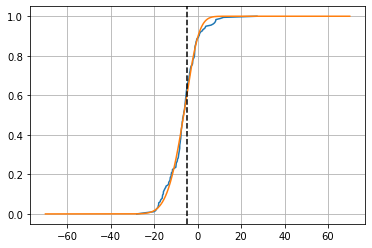

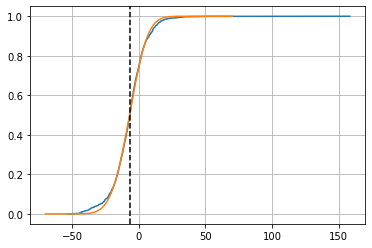

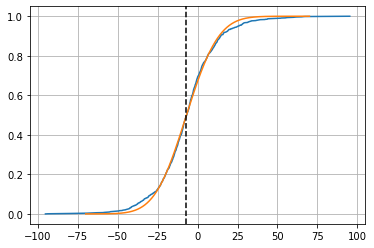

([6.817370096588773, 11.269927714919058, 15.209208336878147],
 [4.5184907770985125, 10.292540674301714, 16.169073080805145],
 [-4.958645270809794, -6.313624515335165, -7.569383592527349])

In [26]:
# store the values for A, F, and G
sigma_v1  = []
sigma_v2 = []
w0 = []
for num in [a_type.w.to_numpy(), f_type.w.to_numpy(), g_type.w.to_numpy()]:
  num = np.sort(num)
  popt, _ = curve_fit(double_gaussian_cum, num, np.linspace(0, 1, len(num)), p0=(1,1, 0))
  sigma_v1_, sigma_v2_, w0_ = popt
  ws = np.linspace(-70, 70, 1000)
  plt.figure()
  plt.plot(num, np.linspace(0, 1, len(num)))
  plt.plot(ws, double_gaussian_cum(ws, *popt))
  plt.axvline(w0_, color="k", ls="--")
  plt.grid()
  plt.show()
  sigma_v1.append(sigma_v1_)
  sigma_v2.append(sigma_v2_)
  w0.append(w0_)
sigma_v1, sigma_v2, w0

In [27]:
df_assy = vaex.from_dict(dict(sigma_v1=sigma_v1, sigma_v2=sigma_v2, w0=w0))
df_assy

#,sigma_v1,sigma_v2,w0
0,6.81737,4.51849,-4.95865
1,11.2699,10.2925,-6.31362
2,15.2092,16.1691,-7.56938


In [28]:
name = "Uncertainty"
data_unc_dir = join(root_data_dir, name)
data_unc_dir

'/home2/s20321005/Thesis-Project/Data/Uncertainty'

In [29]:
df_assy.export_hdf5(join(data_unc_dir, "sys.hdf5"))

In [30]:
df_sys = vaex.open(join(data_unc_dir, "sys.hdf5"))
df_sys

#,sigma_v1,sigma_v2,w0
0,6.81737,4.51849,-4.95865
1,11.2699,10.2925,-6.31362
2,15.2092,16.1691,-7.56938


In [204]:
# run 100 bootstrap resampling
# zz = np.linspace(1, 200, 22)

# # initial values
# rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
# sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# # test the following dark values
# rhoDM = 0.016 # Msun/pc^3
# sigmaDD = 7 # Msun/pc^2
# hDD = 20 # pc

# theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)
# # index 0: A, 1: F, 2: G
# index = 0
# sigma_v1 = df_assy["sigma_v1"].to_numpy()[index]
# sigma_v2 = df_assy["sigma_v2"].to_numpy()[index]
# Zs1, Nus1 = nu_mod(zz, theta, sigma_v1)
# Zs2, Nus2 = nu_mod(zz, theta, sigma_v2)

In [31]:
# sigma_sys = np.abs(Nus1-Nus2)/2
# middle = (Nus1+Nus2)/2
# plt.errorbar(Zs1, middle, yerr=sigma_sys, fmt=".")
# plt.grid()

In function form

In [181]:
# root_data_dir = abspath(join(pardir, "Data"))
# data_dir = join(root_data_dir, "Spectral-Class-Velocity")
# dist = vaex.open(join(data_dir, f"A-type.hdf5"))
# dist = dist.w.to_numpy()
# dist = np.sort(dist)
# popt, _ = curve_fit(double_gaussian_cum, dist, np.linspace(0, 1, len(dist)), p0=(1,1,0))
# popt

array([ 6.8173701 ,  4.51849078, -4.95864527])

In [34]:
# this function is in utils.py
# def asymmerty_uncertainties(zz, theta, tipe="A"):
#   # root_data_dir = abspath(join(pardir, "Data"))
#   data_unc_dir = join(root_data_dir, "Uncertainty")
#   df_popt = vaex.open(join(data_dir, "sys.hdf5"))
#   index = 0 if tipe=="A" else 1 if tipe=="F" else 2
#   sigma_v1 = df_popt["sigma_v1"].to_numpy()[index]
#   sigma_v2 = df_popt["sigma_v2"].to_numpy()[index]
#   logNu1 = nu_mod(zz, theta, sigma_v1)
#   logNu2 = nu_mod(zz, theta, sigma_v2)
#   sigma_sys = np.abs(logNu1-logNu2)/2
#   middle = (logNu1+logNu2)/2
#   return middle, sigma_sys

In [15]:
from utils import asymmerty_uncertainties

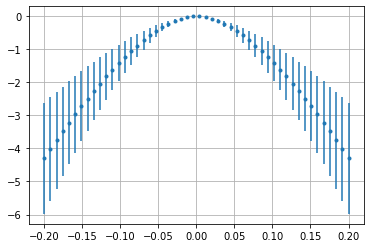

In [41]:
# run 100 bootstrap resampling
zz = np.linspace(-0.2, 0.2, 50)

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

middle, sigma_sys = asymmerty_uncertainties(zz, theta, tipe="A")
plt.errorbar(zz, middle, yerr=sigma_sys, fmt=".")
plt.grid()

## Compare

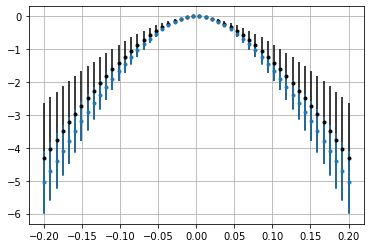

In [42]:
# compare systematic error and statistical error
plt.errorbar(zz, middle, yerr=sigma_sys, fmt=".", c="k")
plt.errorbar(zz, logNu, yerr=logNu_std, fmt=".")
plt.grid()

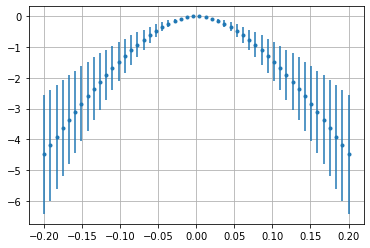

In [47]:
# total mod error
unc_tot = np.sqrt(logNu_std**2+sigma_sys**2)
Nu_mean = (logNu*logNu_std**2+middle*sigma_sys**2)/(logNu_std**2+sigma_sys**2)
plt.errorbar(zz, Nu_mean, yerr=unc_tot, fmt=".")
plt.grid()

all errors in one function

In [13]:
# this function is in utils.py
# def nu_mod_total(zz, theta, tipe="A", res=1000):
#   data_dir = join(root_data_dir, "Velocity-Distribution")
#   df_velocity = vaex.open(join(data_dir, "Velocity-Distribution.hdf5"))
#   index = 0 if tipe=="A" else 1 if tipe=="F" else 2
#   sigma_v = df_velocity["sigma"].to_numpy()[index]
#   logNu_sys, logNu_sys_std = asymmerty_uncertainties(zz, theta, tipe=tipe)
#   logNu_stat, logNu_stat_std = nu_bootstrap(zz, theta, tipe=tipe, res=res)
#   logNu_mean = (logNu_stat*logNu_stat_std**2+logNu_sys*logNu_sys_std**2)/(logNu_stat_std**2+logNu_sys_std**2)
#   logNu_std = np.sqrt(logNu_stat_std**2+logNu_sys_std**2)
#   return logNu_mean, logNu_std

In [5]:
from utils import nu_mod_total

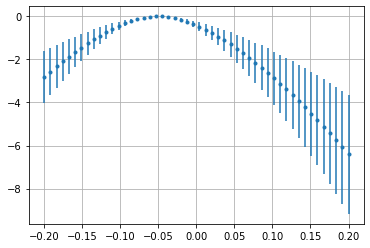

In [6]:
# run 100 bootstrap resampling
zz = np.linspace(-0.2, 0.2, 50)

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0.05)

logNu_mean, logNu_std = nu_mod_total(zz, theta, tipe="A")
plt.errorbar(zz, logNu_mean, yerr=logNu_std, fmt=".")
plt.grid()

Save all relevant functions in utils.py